In [3]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [54]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [129]:
from sklearn.datasets import make_moons

n_samples = 1000
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

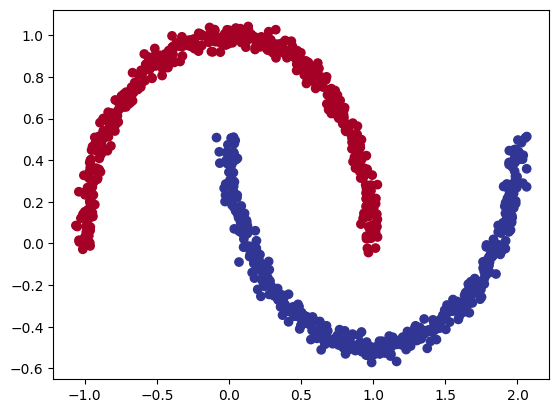

In [131]:
# visualize the data
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

In [132]:
# Build model with non-linear activation function
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModelV2().to(device)
print(model)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [133]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), 
                            lr=0.1)

In [134]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [135]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69537, Accuracy: 37.75% | Test Loss: 0.69457, Test Accuracy: 49.50%
Epoch: 10 | Loss: 0.68200, Accuracy: 76.50% | Test Loss: 0.68206, Test Accuracy: 73.00%
Epoch: 20 | Loss: 0.66786, Accuracy: 79.75% | Test Loss: 0.66920, Test Accuracy: 77.00%
Epoch: 30 | Loss: 0.65071, Accuracy: 77.62% | Test Loss: 0.65313, Test Accuracy: 73.00%
Epoch: 40 | Loss: 0.62607, Accuracy: 76.12% | Test Loss: 0.63009, Test Accuracy: 69.00%
Epoch: 50 | Loss: 0.59334, Accuracy: 75.12% | Test Loss: 0.59957, Test Accuracy: 71.50%
Epoch: 60 | Loss: 0.55276, Accuracy: 76.12% | Test Loss: 0.56132, Test Accuracy: 72.50%
Epoch: 70 | Loss: 0.50709, Accuracy: 77.25% | Test Loss: 0.51803, Test Accuracy: 74.50%
Epoch: 80 | Loss: 0.46099, Accuracy: 78.62% | Test Loss: 0.47418, Test Accuracy: 74.50%
Epoch: 90 | Loss: 0.41996, Accuracy: 80.25% | Test Loss: 0.43486, Test Accuracy: 75.50%
Epoch: 100 | Loss: 0.38636, Accuracy: 81.88% | Test Loss: 0.40196, Test Accuracy: 77.00%
Epoch: 110 | Loss: 0.35933, Accu

In [136]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


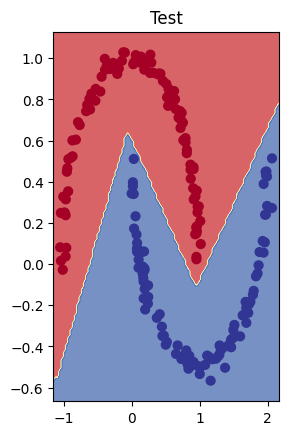

In [137]:

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) # model_3 = has non-linearity